# LangChain Agents - Financial Analysis with Gemini

Complete building production-ready agents with memory, middleware, and streaming

## Overview 
This notebook covers:  
- Short-term Memory: Persist conversation state with SQLite
- Built-in Middleware: Production partterns (summarization, limits, PII detection, todo tracking)
- Structured Output: Type-safe agent responses with Pydantic
- Streaming Modes: Real-time updates (messages, updates, values)

## Setup
Initialize model and tools for financial analysis

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain.agents import create_agent
from scripts import base_tools

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
system_prompt = "You are a financial analyst specializing in tech stocks." \
"Provide data-driven analysis with clear insights." \
"You have access to web_search tools and get_weather tools. "

## 1.Basic Agent
Create simple agent with tools but no memory

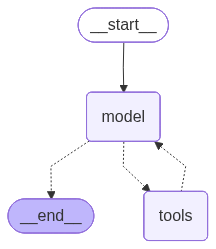

In [6]:
agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt
)
agent

In [8]:
query = "What is the apple's current stock price?"
response = agent.invoke({"messages":[HumanMessage(query)]})

In [9]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price?", additional_kwargs={}, response_metadata={}, id='52efc7db-f7cd-4d5c-a8f4-cf3239f06d1d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple stock price"}'}, '__gemini_function_call_thought_signatures__': {'fa0b05c1-26ea-47cd-bc12-53f343a4a347': 'CrUBAb4+9vtkZ4fFAhhYxXA0GOf6HEuogTdFtknvaB2idlo6mF6D+fK29atVVLXXPSFeLQEvSDO2F0vBzhUJkvIrT8z+uCh7z/IPELTIi0IZNyJw90ATQ1FaQHHEKniA/sTRlKBNDooL03boGMBXVqqz9fMJeeHYQgwlBChZPU137VzVoVRQpmq+sSNgnaSeqWL87vsc4Cg1/tjDX5UADVIfoFj56CSsGnTILmrXK9SguQ4Gn36FRw=='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c2cf8-6792-7b51-9975-256d5e885014-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Apple stock price'}, 'id': 'fa0b05c1-26ea-47cd-bc12-53f343a4a347', 'type': 'tool_call'}], invalid_tool_calls=[], usage

In [10]:
query = "What is the apple's current stock price? and What is the lastest weather in London?"
response = agent.invoke({"messages":[HumanMessage(query)]})

In [11]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price? and What is the lastest weather in London?", additional_kwargs={}, response_metadata={}, id='fa7ac752-f5f6-4cc3-9328-50cbfbad69b4'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'c4589b1f-9dbc-412d-bf07-bcb58f629875': 'Cv8DAb4+9vv275RGwJHPB5e9AalcuLRu+MDIe4/TUo1Gd3EBeersFJivEB8LlwYNxqP54AYpHLETO8WBgeyx8XMbaYbJfJxfjiSdnD1UW76nNDlpZhGse2QdVvhhNJQdkjh96Os7QG2254ok6H5qhJI5IrON0bRS9h0wtYB89IUIAqQJONmjIc2yjMbiYtKytqjYq1ufLyG/WsQAh4AMxIJbVPZk1xkPHl9/22sedrejH8z5s5LDBNiBMc/EuAnaK/EyPvjqr0vxSupX169/29GBa3a7ELzOKxyARvlF3Q6Z9KCsbck7vR+hIkOoEA3rGIw3KqCC+M+oJC4keutK9ZnjlpHMfKV4Zpd2ms2DPrftXddKC7m+9Med+Qub31owSKvqzEuaMfkv/mKlLWoSdkGYQ2DLitB2YjzfQAyeZmdyXbrSIm9Hho/z+1+GWpaUygNgJkFNqpMavuvHa+se5UuM23t18h5peMbyEBYe2UBvI43H3fIJzM/U4xr/OAnuoa5HQezUE0D1V4/wtPuz706MJpNlE/CTRDwy7NRCCxkdq642LepHMiwRFdS6jMJ9X

In [12]:
print(response["messages"][-1].text)

Apple's current stock price is $280.70 as of December 4, 2025, 4:00 p.m. ET.

The latest weather in London is 6.1°C with light drizzle, and it feels like 2.3°C. The wind is from the ESE at 21.2 kph, and humidity is 93%. This information was last updated on 2026-02-05 08:45.


## 2. Short-term Memory with SQLite
Add conversation persistence using SQLite checkpointer. Agents remember previous turns within a session

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("data/financial_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [14]:
agent_memory = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer
)

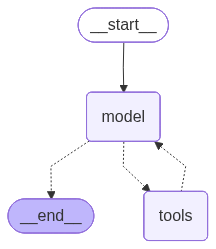

In [15]:
agent_memory

In [16]:
query

"What is the apple's current stock price? and What is the lastest weather in London?"

In [17]:
config = {"configurable": {"thread_id": "memory_session"}}
response = agent_memory.invoke({"messages":[query]}, config=config)

In [18]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price? and What is the lastest weather in London?", additional_kwargs={}, response_metadata={}, id='0974ae67-6bf0-4ba8-a0a2-82bd184f7885'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'68ccbcf7-8c60-44b0-9abf-70da0c3d897b': 'CskDAb4+9vu1Mt1zdtfb8qjMEj+vovj8xyo4eD9RUA+9T7O1VoO03Vc3zkLn+x80AClOCMEjfVwztVe5kZ7Fm13a9KApwBysU3q+cHcbRrCOOqQaZoq0KdGjx4rhq0nxhG1RNknVYOtGlG/DNqEx8nBORivWuyYYnA/sLCzNFb9nAtcdTchKQXppwLNSFFTvFFLvsjeugV1zbustVV9gKWIK1qbEqUGbwnvHFza/u+ZL3ppktc9r0VywpuB2lmuA89lnewEpzqaUs+cO4sx3GA3Zzf4T4gWY9YzmLGGbkfZxBQFlBaeLdlj/96E/ECx7BphDBThWAEVJBYLPzAdSG33ClgIYP2rCdV5W3WaLo1EEQAcoD9m/0qFLJKxhL9Tc3+bJUcf0kyv06PmXMJgi/SHVVsSZ/xvsP1/xdlIarHmjl2bRm5fcs7Cz7LdviK2wAG+zdyL64hs9+3pIX3qj6r+NKLQ6H0zIlUXVDB94171olJGa4w4ifGAjWWI+IA/bzNcxpEaB1uOItfMn6hYEOXmYsBpytIFNoGlCqYuQaAfddG7yEMUMUrZAIIV5Z3Ik+

In [19]:
response = agent_memory.invoke({"messages":["What is the latest US stock news"]}, config=config)

In [20]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price? and What is the lastest weather in London?", additional_kwargs={}, response_metadata={}, id='0974ae67-6bf0-4ba8-a0a2-82bd184f7885'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'68ccbcf7-8c60-44b0-9abf-70da0c3d897b': 'CskDAb4+9vu1Mt1zdtfb8qjMEj+vovj8xyo4eD9RUA+9T7O1VoO03Vc3zkLn+x80AClOCMEjfVwztVe5kZ7Fm13a9KApwBysU3q+cHcbRrCOOqQaZoq0KdGjx4rhq0nxhG1RNknVYOtGlG/DNqEx8nBORivWuyYYnA/sLCzNFb9nAtcdTchKQXppwLNSFFTvFFLvsjeugV1zbustVV9gKWIK1qbEqUGbwnvHFza/u+ZL3ppktc9r0VywpuB2lmuA89lnewEpzqaUs+cO4sx3GA3Zzf4T4gWY9YzmLGGbkfZxBQFlBaeLdlj/96E/ECx7BphDBThWAEVJBYLPzAdSG33ClgIYP2rCdV5W3WaLo1EEQAcoD9m/0qFLJKxhL9Tc3+bJUcf0kyv06PmXMJgi/SHVVsSZ/xvsP1/xdlIarHmjl2bRm5fcs7Cz7LdviK2wAG+zdyL64hs9+3pIX3qj6r+NKLQ6H0zIlUXVDB94171olJGa4w4ifGAjWWI+IA/bzNcxpEaB1uOItfMn6hYEOXmYsBpytIFNoGlCqYuQaAfddG7yEMUMUrZAIIV5Z3Ik+

## 3. Built-in Middleware: Summarization
Automatically summarize old messages when history grows too long
- Usecase: Long conversations that exceed context window

In [9]:
from langchain.agents.middleware import SummarizationMiddleware

In [22]:
agent_summary = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[SummarizationMiddleware(
        model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite"),
        trigger=[("messages", 10)],
        keep=("messages", 5)
    )]
)

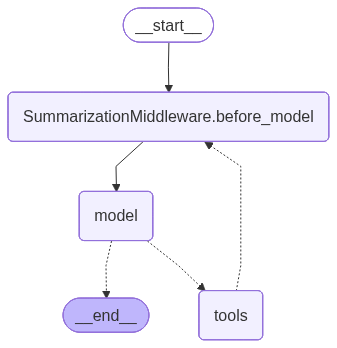

In [23]:
agent_summary

In [ ]:
response = agent_summary.invoke({"messages": ["Tài sản của Elon Musk là bao nhiêu?"]}, config=config)

In [28]:
response

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\n## SESSION INTENT\nThe user wants to know the current stock price of Apple and the latest weather in London.\n\n## SUMMARY\nThe user requested the current stock price of Apple and the latest weather in London.\nI performed a web search for "Apple stock price" and used the `get_weather` tool for "London".\nThe web search results provided two potential stock prices, with the most recent being $280.70 as of December 4, 2025, 4:00 p.m. ET.\nThe `get_weather` tool returned that the latest weather in London, as of February 5, 2026, 09:30 GMT, is 6°C with light drizzle.\n\n## ARTIFACTS\nNone\n\n## NEXT STEPS\nNone', additional_kwargs={'lc_source': 'summarization'}, response_metadata={}, id='9621b7ee-2714-43f8-9815-10d03bea997f'),
  HumanMessage(content='What is the latest US stock news', additional_kwargs={}, response_metadata={}, id='bf1d692a-3bbc-49c9-b795-8bcdc1a5f148'),
  AIMessage(content='', additional

## 4. Middleware: Model and Tool Call Limit
Limit the number of model calls per request to prevent runaway costs  
Exit Behaviors: "end" stop or "continue" proceed without model

In [5]:
from langchain.agents.middleware import ModelCallLimitMiddleware, ToolCallLimitMiddleware, ModelFallbackMiddleware

In [11]:
agent_limit = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        SummarizationMiddleware(
            model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite"),
            trigger=[("messages", 15)],
            keep=("messages", 5)
        ), 
        ModelCallLimitMiddleware(run_limit=2, exit_behavior="end"),
        ToolCallLimitMiddleware(run_limit=2, exit_behavior="continue"),
        ModelFallbackMiddleware(ChatGoogleGenerativeAI(model="gemini-3-pro-preview"))
    ]
)

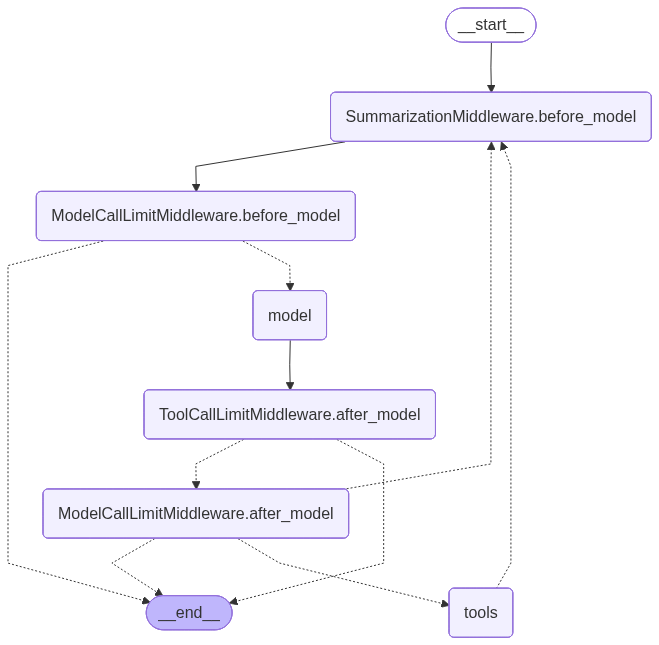

In [12]:
agent_limit

In [16]:
config = {"configurable": {"thread_id": "limit_session"}}

In [19]:
response = agent_limit.invoke({"messages": ["What is the total distance between earth and moon. What is the lastest news on Trump? What is the lastest weather of London"]}, config=config)

In [20]:
response

{'messages': [HumanMessage(content='What is the total distance between earth and moon. What is the lastest news on Trump? What is the lastest weather of London', additional_kwargs={}, response_metadata={}, id='8755ad27-b3ca-4116-8db1-dd505a513cde'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'7757394f-aa5d-4816-931a-2d319681db6b': 'CpUFAb4+9vvZtK25xRvaHGMkCIKPZ+d9Tp5OBiL0Y8T39nnD+j7QpqJ/CWhNo6AHC6nQ4EPpFK+jloRdP2GXxpF3fWcW8cAoT2SguHsQjBCsH7YcztnQEmUCjqaLbPU+U79CQVTnHBUfFAdku5VjVpEdYwOXaOvUB9SOheEgmCHApnZ5MKYvhJYfhBkQLYlr90+MxVUCfY5rMFKNHXFK1OsV5PMRnV9g8wYuC1WG1YZEjb15stQVO7g/2iLm7NbSQa2IMhmKrNdIwoEasHfhUYMIOOJZkGGQ/6n0ayNg1IvN88Ngn2sb4AmG3SApjgqfshbQUsTusTA/QidTQnnBfaUlcWauY1ziH4UHB5TGRbEtgL+FvyTkSaf9QF6rQTfvMr+XgM3aCyKyskBSsHlCdbeAu/civRmaqh1DJPl59CIMOLWIlVf+h0vM6xpD5FKh9MQOo3ScARHyuXZ0ahwDu+haHl1ltkGt2ciD0eM7gTmtGYPZo+KhwtyjNIWK+eIZexiKPSLo5dJoAnVP0ftadY43C

## 5. Middleware: Guardrails and PII Detection
Automatically detect and redact/mask personality identify information  
Stratergies: "redact"(remove), "mask"(replace with ***), "block"(prevent request) 

In [21]:
from langchain.agents.middleware import PIIMiddleware

In [22]:
agent_pii = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        PIIMiddleware("email", strategy="redact", apply_to_input=True)
    ]
)

In [24]:
config = {"configurable": {"thread_id": "pii_session"}}
response = agent_pii.invoke({"messages":[HumanMessage("Hi my name is Tung. here is my email tung.nx20042024@gmail.com")]}, config)

In [25]:
response

{'messages': [HumanMessage(content='Hi my name is Tung. here is my email [REDACTED_EMAIL]', additional_kwargs={}, response_metadata={}, id='a2c0f15e-e23e-4612-a560-b95b2232e6f5'),
  AIMessage(content=[{'type': 'text', 'text': "Hello Tung, it's a pleasure to meet you. How can I assist you with tech stock analysis today?", 'extras': {'signature': 'CvMBAb4+9vtEYTFw9rP6jBFPkc89jIVvRmIWBZm+WsAdD2+d32lzDwyC927PHioxfuUrUVv2uqFMP1LaWlpK7FEFM7O2dCYCViFeJJj61qi77uROm40LLff7I1Ae7muuk7/QSTtt5NRAdqOlD27qUP5neJoMEW6H+MSqhrmya+eC8WpG3LrDb1p5mPkvRtwAcl7i763hoygPJhRy4QJ90Qb0v0q6xi43jvVkCgojZj8b1naW/hlja7JFdjn7h0BBqmbQaZIMC52GR26rXqTojfpmJPqG3XHR6CfP86ga9fao0hazBaU1dv4dqpvJ0x++83ixrrZy'}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c338e-d710-7e42-8491-38072379ffce-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 239, 'output_tokens': 72, 'total_token

## 6. Middleware TODO list
Track and manage multi-step tasks within the agent

In [26]:
from langchain.agents.middleware import TodoListMiddleware

In [27]:
agent_todo = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[TodoListMiddleware()]
)

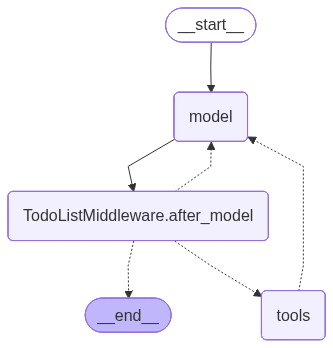

In [28]:
agent_todo

In [31]:
config = {'configurable': {'thread_id': 'todo_session'}}

response = agent_todo.invoke(
    {"messages": [HumanMessage("analyze the apple revenue and compare it with competitors")]},
    config=config
)

In [32]:
response

{'messages': [HumanMessage(content='analyze the apple revenue and compare it with competitors', additional_kwargs={}, response_metadata={}, id='c42034cd-e823-4d11-a0e8-ba43bd40c389'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_todos', 'arguments': '{"todos": [{"content": "Identify Apple\'s key competitors in its major revenue segments (e.g., smartphones, computers, services).", "status": "in_progress"}, {"status": "pending", "content": "Search for Apple\'s most recent annual or quarterly revenue data."}, {"content": "Search for the most recent annual or quarterly revenue data for identified competitors, ensuring comparable periods.", "status": "pending"}, {"content": "Analyze and compare Apple\'s revenue with its competitors, highlighting key insights.", "status": "pending"}, {"status": "pending", "content": "Present the comprehensive analysis to the user."}]}'}, '__gemini_function_call_thought_signatures__': {'ebc3f240-2480-4691-adca-0e8eb8862aa2': 'Cs

In [33]:
print(response["messages"][-1].text)

Here's an analysis of Apple's recent revenue performance and a comparison with its key competitors, based on their latest reported quarterly results (for periods ending around December 2025):

**Apple's Revenue Performance (Q1 Fiscal Year 2026, ended December 27, 2025):**
*   **Total Revenue:** $143.8 billion

**Key Competitors' Revenue Performance (Q4 2025, ended December 31, 2025):**
*   **Amazon:** $213.39 billion
*   **Alphabet (Google):** $113.8 billion
*   **Microsoft:** $81.3 billion
*   **Samsung Electronics:** ~$65.60 billion (converted from KRW 93.8 trillion)

**Comparative Analysis and Key Insights:**

1.  **Overall Revenue Scale:**
    *   **Amazon** leads in this comparison with the highest quarterly revenue of $213.39 billion. This reflects its vast e-commerce operations, which generate significant sales volume, complemented by its rapidly growing and highly profitable Amazon Web Services (AWS) cloud division.
    *   **Apple** holds a strong second position with $143.8 b

## 7. Streaming: Messages Mode
Three streaming modes for real-time agent updates:
- messages: Stream individual messages as they're generated
- updates: Stream state updates after each step 
- values: Stream complete state values

In [34]:
agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt
)

In [36]:
config = {'configurable': {'thread_id': 'stream_session'}}

for chunk in agent.stream({"messages": ["tell me about the apple news"]}, stream_mode="values",config=config):
    print(chunk)
    print("---------\n")


{'messages': [HumanMessage(content='tell me about the apple news', additional_kwargs={}, response_metadata={}, id='0b899db7-ecfa-4b15-bfea-0e91aa77eac5')]}
---------

{'messages': [HumanMessage(content='tell me about the apple news', additional_kwargs={}, response_metadata={}, id='0b899db7-ecfa-4b15-bfea-0e91aa77eac5'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple Inc. news"}'}, '__gemini_function_call_thought_signatures__': {'9ad76d8f-8d29-4806-9b64-98fcf8aad9d0': 'CvcCAb4+9vs+z+XL6CZCJ1dIWZM1fawvrLJl+29nyUTjaCXS/PA3rf4XX+WkOPk/Z8nKSbvtn72Apf3m5vM3yNwfdE16g8y6WSbJjCa90Je2VCs1NrYFW5mm6u1pMeFCagZpZ714myWUUu/oObfR/89LDrIkhUmoP5GUj+TwTZyq09ECLPB1h/WstL9tuaQtssPFXnEn1Lx0D+omCfloBR2KkiOd4KAHoz27TpTr9QUOon9ls1eY5nR3eu29tiZpfF7qXUDjtYrIZ/126jcm9D4RoiCBuH4YMseXr3QStDYMPkEg8vBhYahAvgEauyMH9bp5LGhwAOLWYJq04Udvp5ct+PxvdixuUD6hKf49plSuqdiYUXkbUbpIh+aMNFOD3A1HbaE5mvuWr67Gr4mMLDtFclzL6oM8w1Y6kvPKsI8EPpc+8WbqMT84vI+szmZTHxk3YcnEU2BCKi